In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

In [3]:
try:
    import gpflux
except ModuleNotFoundError:
    %pip install gpflux
    import gpflux

from gpflux.architectures import Config, build_constant_input_dim_deep_gp
from gpflux.models import DeepGP

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install tensorflow
    import tensorflow as tf
    
import numpy as np
import pandas as pd
import gpflow
import gpflux


from gpflux.architectures import Config, build_constant_input_dim_deep_gp
from gpflux.models import DeepGP

# we want to carry out GP calculations in 64 bit
tf.keras.backend.set_floatx("float64")
tf.get_logger().setLevel("INFO")

import tensorflow as tf
import gpflow
import gpflux
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_probability as tfp
from sklearn.neighbors import KernelDensity

import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np
tf.keras.backend.set_floatx("float64")

In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [5]:

def dataset_loader(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    # torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
    
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)



    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1)
    y_train = torch.tensor(y_train).reshape(-1,)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1)
    y_test = torch.tensor(y_test).reshape(-1,)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y


In [6]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)

/tmp/ipykernel_1339627/3396249836.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,)


In [7]:
x_train_full = torch.cat((x_train, x_train_timestamp), axis=1)
x_test_full = torch.cat((x_test, x_test_timestamp), axis=1)
x_train_full.shape, x_test_full.shape

(torch.Size([53456, 2]), torch.Size([16781, 2]))

In [8]:
num_data = x_train.shape[0]
w_dim = 2
prior_means = np.zeros(w_dim)
prior_std = np.ones(w_dim)
encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
prior = tfp.distributions.MultivariateNormalDiag(prior_means, prior_std)
lv = gpflux.layers.LatentVariableLayer(prior, encoder)

/tmp/ipykernel_1339627/3005490755.py:5: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
/tmp/ipykernel_1339627/3005490755.py:7: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  lv = gpflux.layers.LatentVariableLayer(prior, encoder)


In [9]:
NUM_INDUCING = 5096
kernel = gpflow.kernels.SquaredExponential(lengthscales=[.05, .2], variance=1.)
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.concatenate(
        [
            np.linspace(x_train.min(), x_train.max(), NUM_INDUCING).reshape(-1, 1),
            np.random.randn(NUM_INDUCING, 1),
        ],
        axis=1
    )
)
gp_layer = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Zero(),
)

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


In [10]:
kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.random.randn(NUM_INDUCING, 1),
)
gp_layer2 = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Identity(),
)
gp_layer2.q_sqrt.assign(gp_layer.q_sqrt * 1e-5);

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.random.randn(NUM_INDUCING, 1),
)
gp_layer3 = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Identity(),
)
gp_layer3.q_sqrt.assign(gp_layer2.q_sqrt * 1e-5);

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.random.randn(NUM_INDUCING, 1),
)
gp_layer4 = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Identity(),
)
gp_layer4.q_sqrt.assign(gp_layer3.q_sqrt * 1e-5);

In [11]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.0001))
gpflow.set_trainable(likelihood_layer, False)
dgp = gpflux.models.DeepGP([lv, gp_layer, gp_layer2, gp_layer3, gp_layer4], likelihood_layer)
gpflow.utilities.print_summary(dgp, fmt="notebook")

/tmp/ipykernel_1339627/1245979906.py:1: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.0001))
2022-07-15 23:19:32.717612: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._self_tracked_trackables[1]._trainable_weights[0] DeepGP.f_layers[0].encoder._trainable_weights[0],ResourceVariable,,,True,"(53456, 2)",float64,"[[0.00437402, -0.00694302..."
DeepGP.f_layers[0]._self_tracked_trackables[1]._trainable_weights[1] DeepGP.f_layers[0].encoder._trainable_weights[1],ResourceVariable,,,True,"(53456, 2)",float64,"[[-11.51292046, -11.51292046..."
DeepGP.f_layers[0]._self_tracked_trackables[1]._self_tracked_trackables[0] DeepGP.f_layers[0]._self_tracked_trackables[1].means DeepGP.f_layers[0].encoder._self_tracked_trackables[0] DeepGP.f_layers[0].encoder.means,Parameter,Identity,,True,"(53456, 2)",float64,"[[0.00437402, -0.00694302..."
DeepGP.f_layers[0]._self_tracked_trackables[1]._self_tracked_trackables[1] DeepGP.f_layers[0]._self_tracked_trackables[1].stds DeepGP.f_layers[0].encoder._self_tracked_trackables[1] DeepGP.f_layers[0].encoder.stds,Parameter,Softplus,,True,"(53456, 2)",float64,"[[1.e-05, 1.e-05..."
DeepGP.f_layers[1]._trainable_weights[0],ResourceVariable,,,True,"(5096, 1)",float64,[[0....
DeepGP.f_layers[1]._trainable_weights[1],ResourceVariable,,,True,"(1, 12987156)",float64,"[[1., 0., 0...."
DeepGP.f_layers[1]._self_tracked_trackables[1].variance DeepGP.f_layers[1].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
DeepGP.f_layers[1]._self_tracked_trackables[1].lengthscales DeepGP.f_layers[1].kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.05 0.2 ]
DeepGP.f_layers[1]._self_tracked_trackables[2].Z DeepGP.f_layers[1].inducing_variable.Z,Parameter,Identity,,True,"(5096, 2)",float64,"[[-0.48580545, 0.83722631..."
DeepGP.f_layers[1]._self_tracked_trackables[4] DeepGP.f_layers[1].q_mu,Parameter,Identity,,True,"(5096, 1)",float64,[[0....


In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
tf.debugging.set_log_device_placement(True)

In [14]:
model = dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))
history = model.fit({"inputs": tf.constant(x_train_full), "targets": tf.constant(y_train.reshape(-1,1))}, epochs=int(2000), verbose=1, batch_size=num_data, shuffle=False)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Epoch 1/2000


ValueError: in user code:

    File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 220, in __call__
        distribution, _ = super(DistributionLambda, self).__call__(

    ValueError: Exception encountered when calling layer "gp_layer" (type GPLayer).
    
    in user code:
    
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflux/layers/gp_layer.py", line 284, in call  *
            outputs = super().call(inputs, *args, **kwargs)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 226, in call  **
            distribution, value = super(DistributionLambda, self).call(
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py", line 196, in call
            result = self.function(inputs, **kwargs)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/tensorflow_probability/python/layers/distribution_layer.py", line 166, in _fn
            d = make_distribution_fn(*fargs, **fkwargs)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflux/layers/gp_layer.py", line 323, in _make_distribution_fn
            mean, cov = self.predict(
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflux/layers/gp_layer.py", line 257, in predict
            mean_cond, cov = conditional(
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/multipledispatch/dispatcher.py", line 278, in __call__
            return func(*args, **kwargs)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/conditionals/conditionals.py", line 80, in _sparse_conditional
            return posterior.fused_predict_f(Xnew, full_cov=full_cov, full_output_cov=full_output_cov)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/posteriors.py", line 210, in fused_predict_f
            mean, cov = self._conditional_fused(
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/posteriors.py", line 766, in _conditional_fused
            Kmn = covariances.Kuf(self.X_data, self.kernel, Xnew)  # [M, N]
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/multipledispatch/dispatcher.py", line 278, in __call__
            return func(*args, **kwargs)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/covariances/kufs.py", line 28, in Kuf_kernel_inducingpoints
            return kernel(inducing_variable.Z, Xnew)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/kernels/base.py", line 189, in __call__
            return self.K(X, X2)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/kernels/stationaries.py", line 93, in K
            r2 = self.scaled_squared_euclid_dist(X, X2)
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/kernels/stationaries.py", line 109, in scaled_squared_euclid_dist
            return square_distance(self.scale(X), self.scale(X2))
        File "/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpflow/kernels/stationaries.py", line 69, in scale
            X_scaled = X / self.lengthscales if X is not None else X
    
        ValueError: Dimensions must be equal, but are 4 and 2 for '{{node model/gp_layer/truediv_2}} = RealDiv[T=DT_DOUBLE](model/gp_layer/strided_slice_6, model/gp_layer/truediv_2/softplus_CONSTRUCTED_AT_top_level/forward/IdentityN)' with input shapes: [53456,4], [2].
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(53456, 4), dtype=float64)
      • args=<class 'inspect._empty'>
      • kwargs={'training': 'True'}


In [15]:
prediction_model = dgp.as_prediction_model()
out = prediction_model(tf.constant(x_test))
y_mean = out.y_mean
y_sigma = out.y_var ** .5 


In [18]:
y_mean = scaler_y.inverse_transform(np.array(y_mean).reshape(-1,1)).squeeze()
y_sigma = scaler_y.inverse_transform(np.array(y_sigma).reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

torch.Size([16781]) (16781,)


In [19]:
mae = np.mean(np.abs(np.array(y_test) - y_mean))
# rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
# print("RMSE: ", rms)

MAE:  5177.308716524688


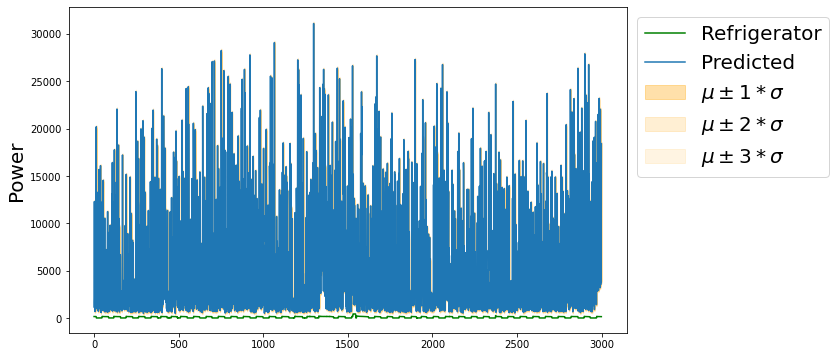

In [20]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test.cpu()[:idx], label = "Refrigerator", color="green")
plt.plot(jnp.arange(idx), y_mean[:idx].reshape(-1,1), label = "Predicted")
for i in range(1,4):
    plt.fill_between(jnp.arange(idx), y_mean[:idx] - i*y_sigma[:idx], y_mean[:idx] + i*y_sigma[:idx],
                    color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.ylabel("Power", fontsize=20)
# sns.despine()
plt.savefig("gp_ref_full__matern.png")